# Tutorial for quante_carlo
- <b>quante_carlo</b> is a multiprocess hyperparameter tuning module. 
- This notebook demonstrates how to use this module to determine the number of neurons to use in a pytorch neural network.

In [2]:
#from sklearn.model_selection import cross_val_score
import pandas as pd
import quante_carlo as qc
#from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern
import time
import numpy as np
#import torch
import multiprocessing as mp
#from multiprocessing.pool import ThreadPool as tp
from torch import nn
import worker

In [1]:
cd ../quante_carlo

/home/ec2-user/SageMaker/projects/quante_carlo/quante_carlo


In [67]:
from importlib import reload 
from scipy.stats import multivariate_normal as mvn

In [68]:
worker = reload(qc)

## This tutorial uses mnist dataset available <a href="https://www.kaggle.com/code/imdevskp/digits-mnist-classification-using-cnn">here</a>

### Multiprocessing
Note to person giving demo:
    <code>gunicorn -w 18 'flask_worker:app'</code>

Included with this repository is a file named worked.py. It's better to put the objective function you want to optimize in a file.
<br> In this example, the worker.py file defines an evaluation function called instance





- The function takes the parameters for each instance from a field defined by the key 'hparameters'.
- The function also returns 1 - loss because the NeuralNetwork is minimizing loss and the Optimizer is set to 'maximize' the function.


### Main 
- The network has 3 hidden layers and the ranges of each layer are as follows: [[32, 512], [32, 1024], [32, 512]],
- Notice that there are 16 gpr processors (Bayesian Optimization step) and 4 GPU processers (training step)
- Because the output layer is a vector of length 10 of ones and zeros we are using BCEWithLogitsLoss.
- I am not using a softmax final function because for prediction, it seems to perform better without one.

In [12]:

gbatch_size = 2000                     # number of elements in the gaussian optimzation batch
g_procs = 6                            # cpus, number of batches for the gaussian optimization phase
hp_ranges = [[32, 512], [32, 1024],    # the user defined function has to determine what to do with
             [32, 512], [.0001, .01]]  # numbers randomly generated from this field
n_procs = 3                            # number of gpus, need to be careful if using all 4, weird things can happen
n_iter = 100                           # bayes iterations
logfile_name = 'logs/logfile_5.txt'


oparameters = {'input_layer_size': 28*28, 
               'output_layer_size': 10, 
               'train_iterations': 300,
               'n_batches': 11,           # number of batches for training?
               'batch_size': .08,
               'train_test_files': {'x_train': 'nn_datasets/X_train.csv', 
                                    'x_test': 'nn_datasets/X_train.csv',
                                    'y_train': 'nn_datasets/y_train.csv', 
                                    'y_test': 'nn_datasets/y_test.csv'}}


In [ ]:
if __name__ == '__main__':
    
    hp_tune = qc.hp_tune(worker.instance,
                         limits=hp_ranges, 
                         gpr_batch_size=gbatch_size, n_gpr_processors=g_procs, 
                         n_processors=n_procs, n_iterations=n_iter, 
                         other_parameters = oparameters, log_file=logfile_name)
    p = mp.Pool()
    start = time.time()    
    session = hp_tune(p)

    print("{} seconds".format(round(time.time() - start,2)))
    p.close()
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [11]:
summary = session.summary()
summary

,iteration,score,hparameters,qEi
0,0,0.946072,"(461, 218, 322)",-1.000000
1,0,0.939908,"(289, 141, 91)",-1.000000
2,0,0.940852,"(311, 93, 178)",-1.000000
3,1,0.939034,"(43, 583, 64)",1.383682
4,1,0.941717,"(497, 42, 65)",1.383682
...,...,...,...,...
298,99,0.944548,"(371, 727, 43)",0.052615
299,99,0.947175,"(445, 828, 38)",0.052615
300,100,0.946348,"(464, 797, 35)",0.058358
301,100,0.943807,"(442, 174, 84)",0.058358


In [9]:
import matplotlib.pyplot as plt

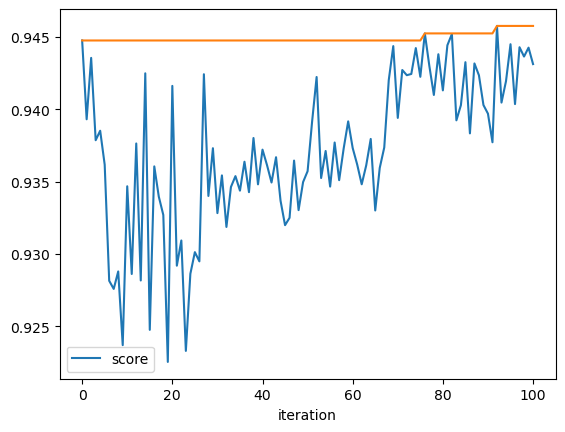

In [7]:
n = summary[['score', 'iteration']].groupby('iteration').max().plot()
best = [max(summary[summary['iteration']<=i]['score']) for i in range(n_iter+1)]
p = plt.plot(best)
plt.savefig('hptune.png')

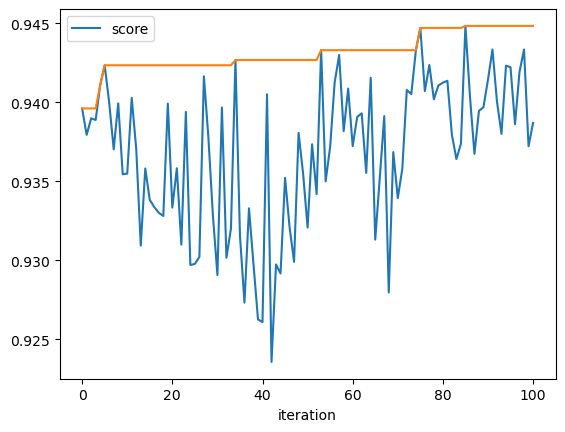

In [11]:
n = summary[['score', 'iteration']].groupby('iteration').max().plot()
best = [max(summary[summary['iteration']<=i]['score']) for i in range(n_iter+1)]
p = plt.plot(best)
plt.savefig('hptune.png')

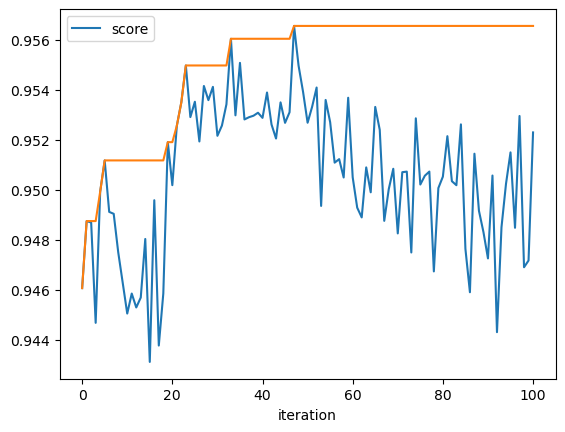

In [12]:
n = summary[['score', 'iteration']].groupby('iteration').max().plot()
best = [max(summary[summary['iteration']<=i]['score']) for i in range(n_iter+1)]
p = plt.plot(best)
plt.savefig('hptune.png')

In [13]:
import neptune
run = neptune.init_run(
    project="mshipman/HPTune",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzNzhiNTgwMC05MDAzLTQ4NTQtOTk1NC04YWFlN2JkMDg4NWEifQ==",
)

summary.to_csv("summary.csv", index=False)
run["summary/score_history.csv"].upload("summary.csv")

params = {"limits": '('+') ('.join(["{},{}".format(x[0], x[1]) for x in hp_ranges])+')', 
          "gpr_batch_size": gbatch_size,
          "n_gpr_processors": g_procs, "n_processors": n_procs,
          "n_iterations": n_iter, "other_parameters": oparameters}
run["parameters"] = params
run["summary/best_by_iteration.png"].upload("hptune.png")
run['historical/best'] = ','.join([str(x) for x in best])
run["log"].upload(logfile_name)
run.stop()


ModuleNotFoundError: No module named 'neptune'